In [1]:
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import pickle

import logging

import random
random.seed(seed)

In [2]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [5]:
training_data = np.load("training_data.npy").astype(np.float32)
categories = np.load("categories.npy")
valid_periods=np.load("valid_periods.npy")
categories_unique = np.unique(categories)

print(training_data.shape)
print(valid_periods.shape)
print(categories.shape)

(48000, 2776)
(48000, 2)
(48000,)


In [6]:
def plot_data_samples(data, lables):
    plt.figure(figsize=(20,10))
    for i in range(len(categories_unique)):
        plt.plot(data[lables==categories_unique[i],:][0])
    plt.legend(categories_unique)
    plt.show()

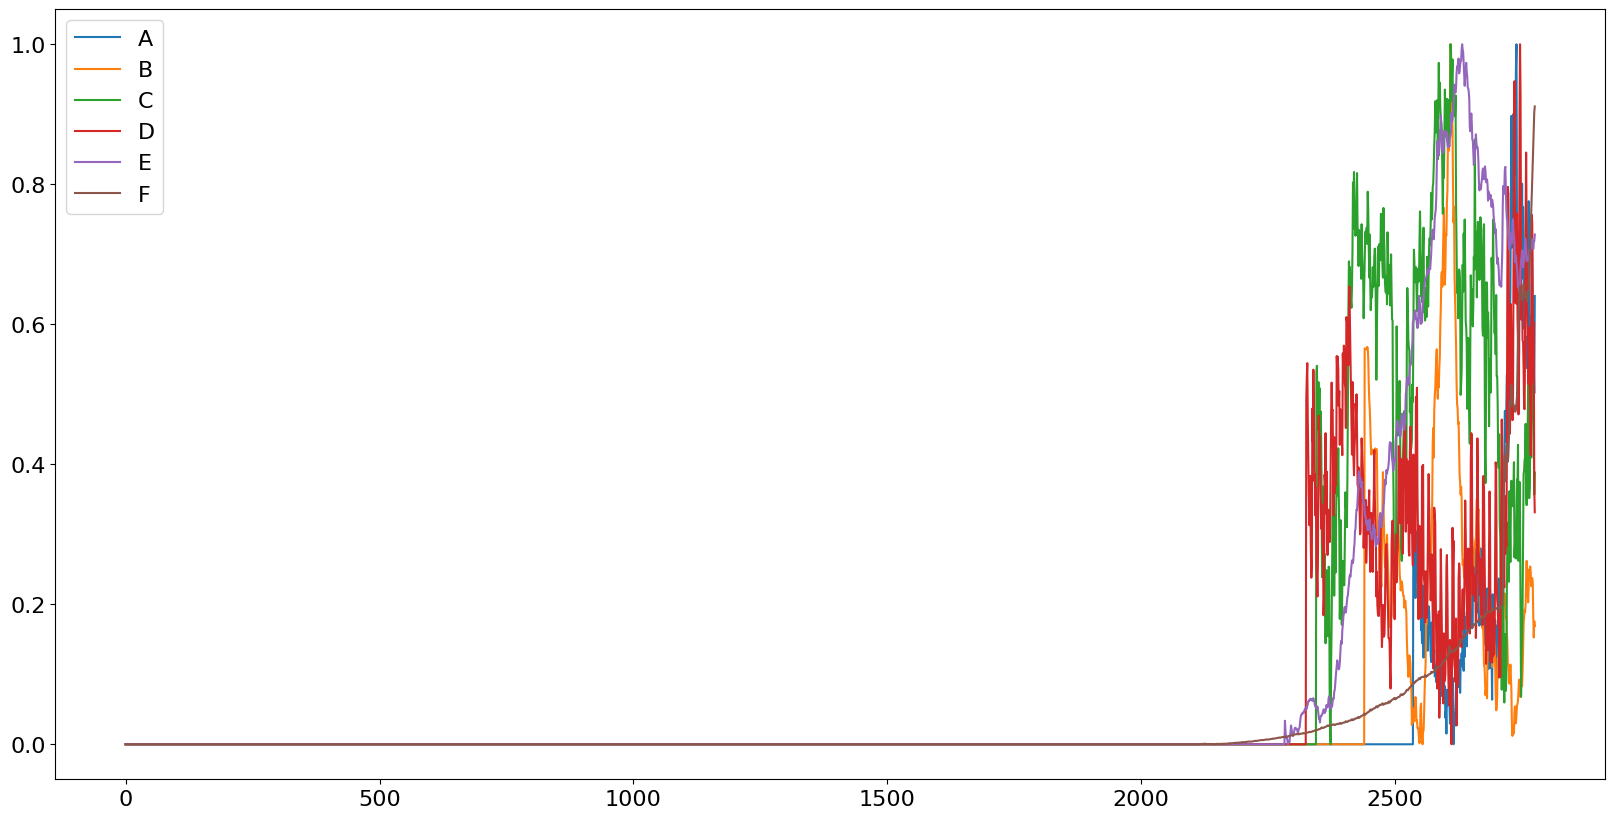

In [7]:
plot_data_samples(training_data, categories)

[   0 2776]
[2752 2776]


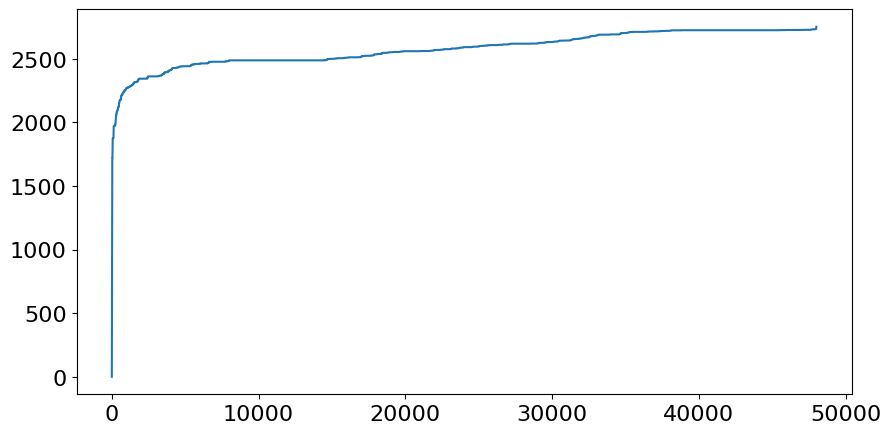

In [8]:
print(valid_periods.min(axis=0))
print(valid_periods.max(axis=0))

starting_times = np.sort(valid_periods[:,0])
plt.figure(figsize=(10,5))
plt.plot(starting_times)
plt.show()

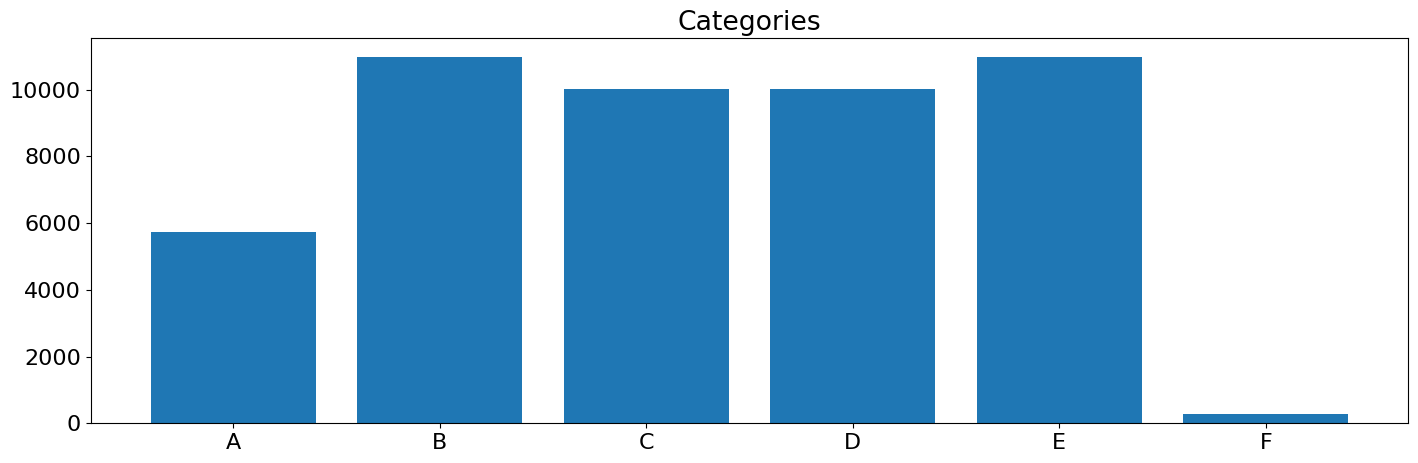

In [9]:
plt.figure(figsize=(17,5))
categories_unique, categories_counts = np.unique(categories, return_counts=True)
plt.bar(categories_unique, categories_counts)
plt.title('Categories')
plt.show()

In [10]:
sample_lengths = valid_periods[:,1]-valid_periods[:,0]

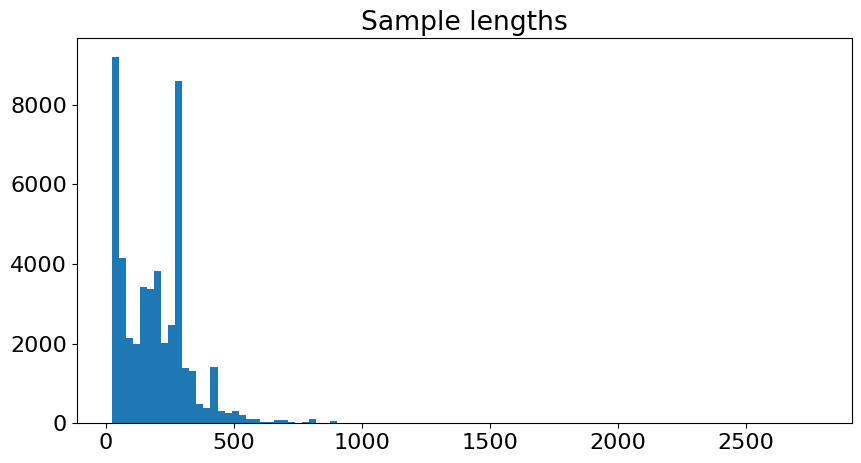

In [11]:
plt.figure(figsize=(10,5))
plt.hist(sample_lengths, bins=100)
plt.title('Sample lengths')
plt.show()

In [12]:
print(np.std(sample_lengths))
print(np.mean(sample_lengths))

#Number of samples outside standard deviation
print(np.sum(sample_lengths>np.mean(sample_lengths)+np.std(sample_lengths)))
print(np.sum(sample_lengths<np.mean(sample_lengths)+np.std(sample_lengths)))

_, distribution_of_sample_categories_outside_std = np.unique(categories[sample_lengths>np.mean(sample_lengths)+np.std(sample_lengths)], return_counts=True)

137.40486378441685
198.30022916666667
4810
43190


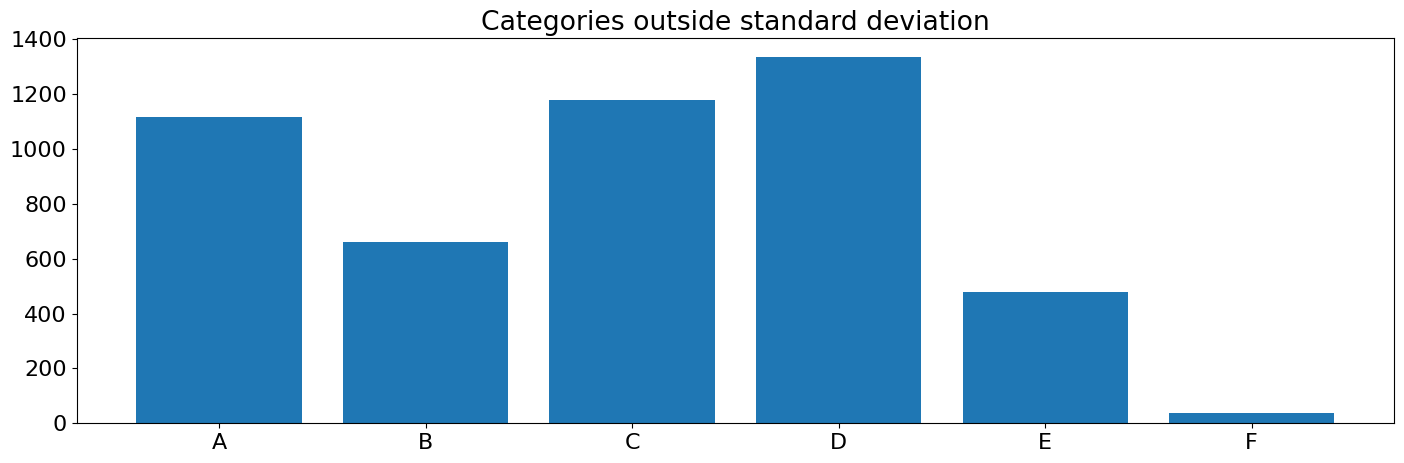

In [13]:
plt.figure(figsize=(17,5))
plt.bar(categories_unique, distribution_of_sample_categories_outside_std)
plt.title('Categories outside standard deviation')
plt.show()

In [14]:
dataset = []
labels = []
window_length = 450

skipped_samples = 0
for i in range(len(valid_periods)):
    from_time = valid_periods[i,0]
    to_time = valid_periods[i,1]
    if(to_time-from_time>window_length):
        skipped_samples+=1
        continue
    sample = training_data[i][from_time:to_time]
    if(len(sample)<window_length):
        sample = np.pad(sample, (0, window_length-len(sample)), 'constant')
    
    dataset.append(sample)
    labels.append(categories[i])

labels = np.array(labels)
dataset = np.array(dataset)
dataset = dataset.reshape((dataset.shape[0], dataset.shape[1], 1))
print("Skipped samples: ", skipped_samples)

Skipped samples:  1762


In [15]:
dataset.shape, labels.shape

((46238, 450, 1), (46238,))

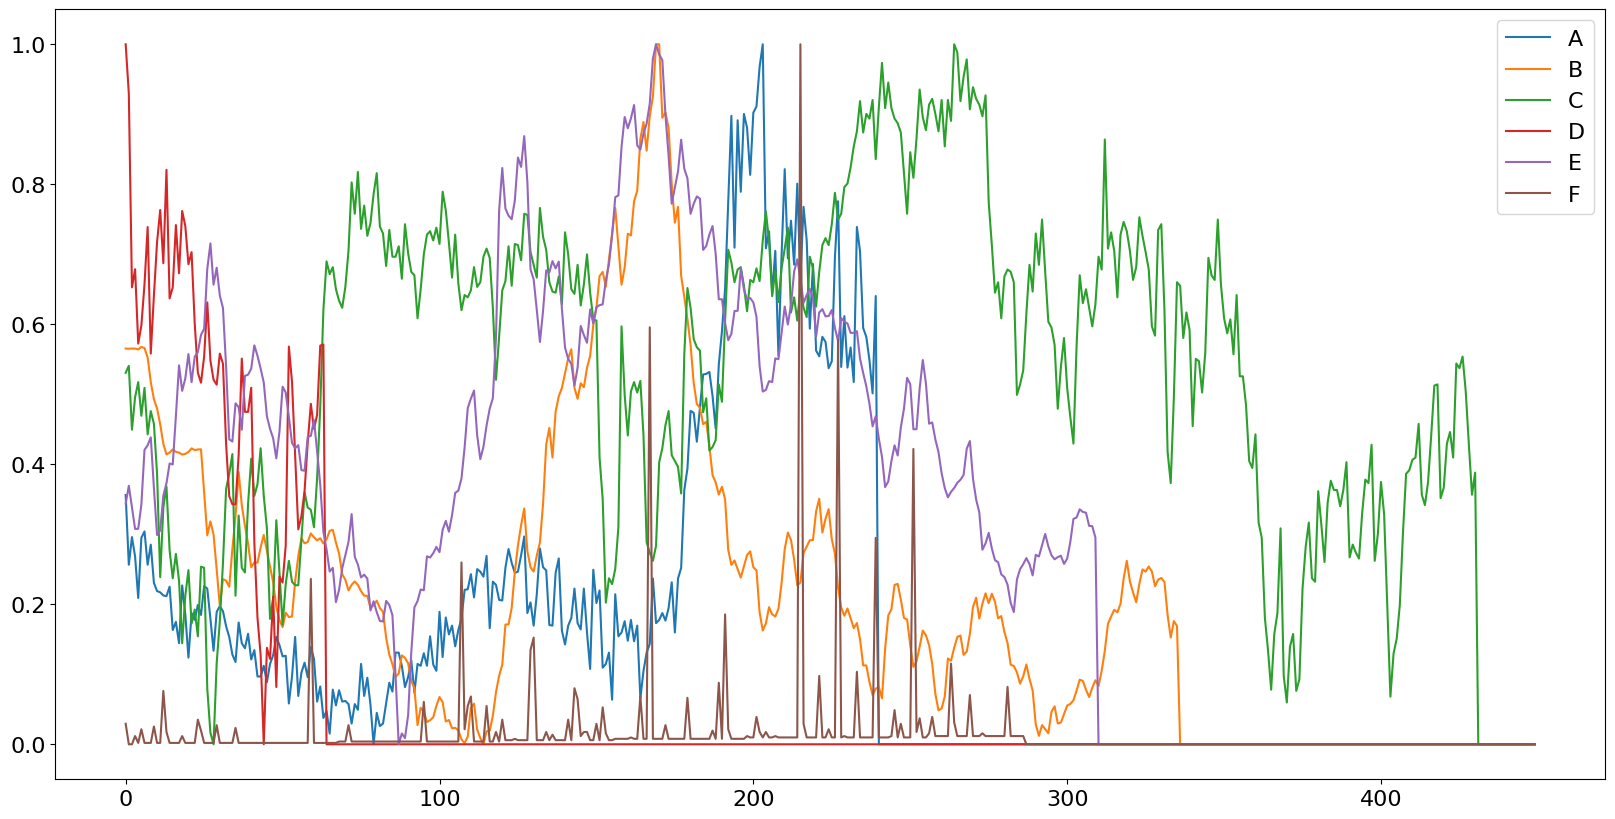

In [16]:
plot_data_samples(dataset, labels)

In [17]:
enc = OneHotEncoder(handle_unknown='ignore')
y_data = enc.fit_transform(categories.reshape(-1, 1)).toarray()

In [18]:
dataset = training_data.reshape((training_data.shape[0], training_data.shape[1], 1))
dataset.shape

(48000, 2776, 1)

In [19]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    dataset, y_data, random_state=seed, test_size=0.2, stratify=y_data)

In [20]:
X_train_val.shape, y_train_val.shape, X_test.shape, y_test.shape

((38400, 2776, 1), (38400, 6), (9600, 2776, 1), (9600, 6))

In [21]:
input_shape = X_train_val.shape[1:]
classes = y_train_val.shape[-1]
batch_size = 32
epochs = 10

In [22]:
classes

6

In [37]:
def build_LSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    lstm = tfkl.LSTM(128, return_sequences=True)(input_layer)
    lstm = tfkl.LSTM(128)(lstm)
    dropout = tfkl.Dropout(.5, seed=seed)(lstm)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [38]:
model = build_LSTM_classifier(input_shape, classes)
model.summary()

TypeError: Missing required positional argument

In [25]:
# Train the model
# history = model.fit(
#     x = X_train_val,
#     y = y_train_val,
#     batch_size = batch_size,
#     epochs = epochs,
#     validation_split=.1,
#     callbacks = [
#         tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
#         tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
#     ]
# ).history

In [26]:
#np.save('results/vanillaModel.npy', history)
#model.save('models/vanillaModel')

In [27]:
def show_model_performance(model, history):
    best_epoch = np.argmax(history['val_accuracy'])
    plt.figure(figsize=(17,4))
    plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
    plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.title('Categorical Crossentropy')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

    plt.figure(figsize=(17,4))
    plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
    plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

    plt.figure(figsize=(17,4))
    plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

    # Predict the test set with the LSTM
    predictions = model.predict(X_test, verbose=0)
    predictions.shape

    # Compute the confusion matrix
    cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

    # Compute the classification metrics
    accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
    precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    print('Accuracy:',accuracy.round(4))
    print('Precision:',precision.round(4))
    print('Recall:',recall.round(4))
    print('F1:',f1.round(4))

    # Plot the confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(cm.T, cmap='Blues')
    plt.xlabel('True labels')
    plt.ylabel('Predicted labels')
    plt.show()

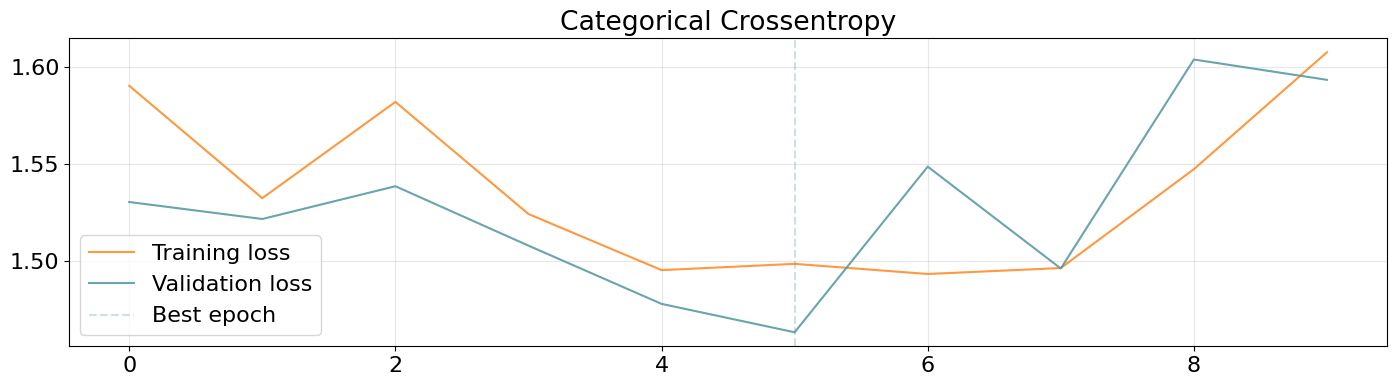

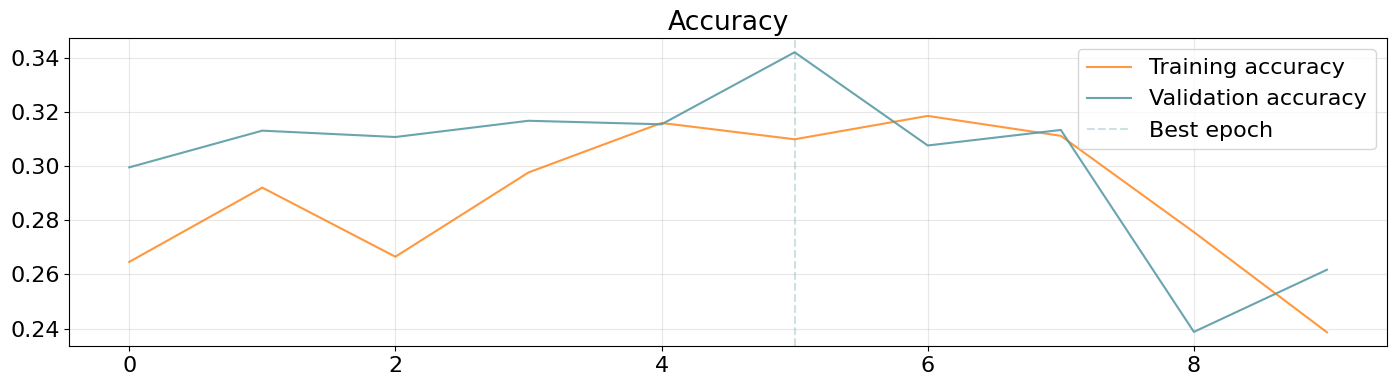

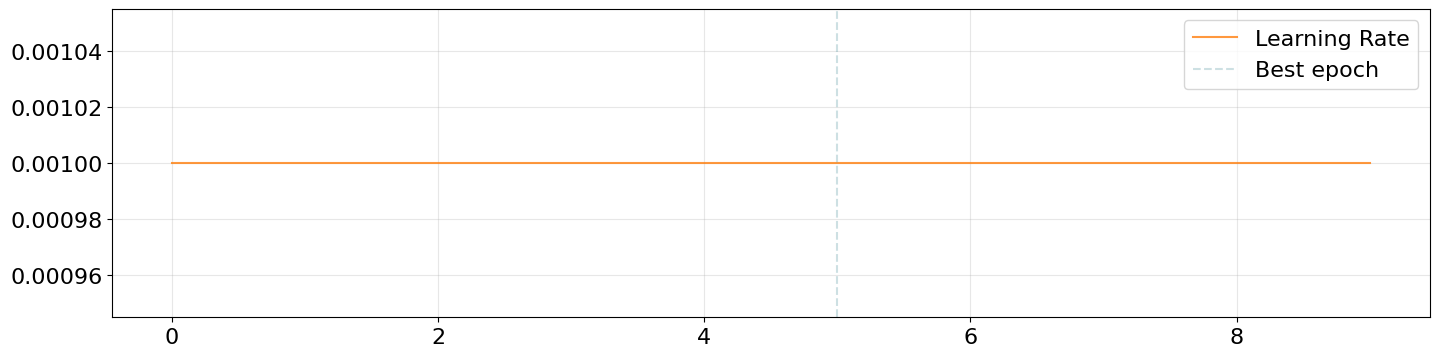

Accuracy: 0.2594
Precision: 0.0861
Recall: 0.189
F1: 0.1183


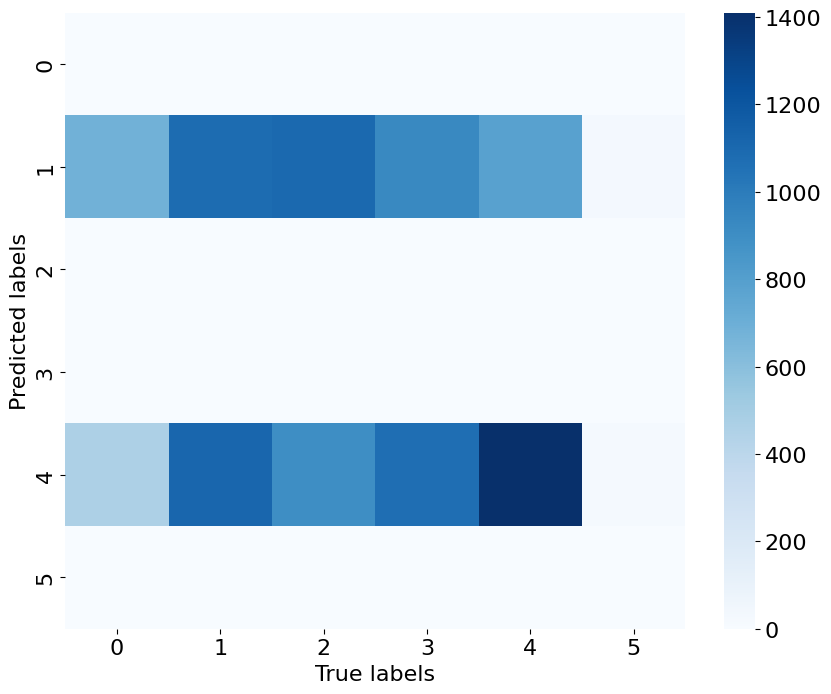

In [28]:
model = tfk.models.load_model('models/vanillaModel')
history = np.load('results/vanillaModel.npy', allow_pickle=True).item()
show_model_performance(model, history)
del model, history

Bidirectional Long Short Term Memory NN

In [32]:
def build_BiLSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128))(bilstm)
    dropout = tfkl.Dropout(.5, seed=seed)(bilstm)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=0.01), metrics='accuracy')

    # Return the model
    return model

In [33]:
model = build_BiLSTM_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2776, 1)]         0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 2776, 256)         133120    
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774   

In [34]:
# Train the model
history = model.fit(
    x = X_train_val,
    y = y_train_val,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/10
1080/1080 [==============================] - 733s 675ms/step - loss: 1.6247 - accuracy: 0.2200 - val_loss: 1.6202 - val_accuracy: 0.2388 - lr: 0.0100
Epoch 2/10
  14/1080 [..............................] - ETA: 11:17 - loss: 1.6594 - accuracy: 0.2009

KeyboardInterrupt: 